In [1]:
from google.colab import drive

In [2]:
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
import os
import nltk

# os.environ['NLTK_DATA'] = '/Users/elder/nltk_data'
# nltk.data.path.append(os.environ['NLTK_DATA'])

In [4]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import string
import re
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
from sklearn.utils import resample
import scipy.stats as stats
import os
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix

In [5]:
# nltk_data_path = os.path.expanduser('~/nltk_data')
# nltk.data.path.append(nltk_data_path)

# Re-download to be safe
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('omw-1.4')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data] Downloading package omw-1.4 to /root/nltk_data...


True

In [6]:
data_fake = pd.read_csv('/content/drive/MyDrive/data_fake_news/Fake.csv')
data_true = pd.read_csv('/content/drive/MyDrive/data_fake_news/True.csv')
df_news = pd.read_csv('/content/drive/MyDrive/data_fake_news/news.csv')

In [7]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [8]:
data_fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [9]:
data_true.head()

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"


In [10]:
data_fake["class"] = 0
data_true["class"] = 1

In [11]:
data_fake.shape, data_true.shape

((23481, 5), (21417, 5))

In [12]:
# Merge datasets
df = pd.concat([data_fake, data_true], ignore_index=True)

In [13]:
# Shuffle data
data = df.sample(frac=1, random_state=42).reset_index(drop=True)

In [14]:
# Check missing values
print(df.isnull().sum())

# Check duplicates
print(df.duplicated().sum())

# Data types and structure
print(df.info())

title      0
text       0
subject    0
date       0
class      0
dtype: int64
209
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 44898 entries, 0 to 44897
Data columns (total 5 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   title    44898 non-null  object
 1   text     44898 non-null  object
 2   subject  44898 non-null  object
 3   date     44898 non-null  object
 4   class    44898 non-null  int64 
dtypes: int64(1), object(4)
memory usage: 1.7+ MB
None


In [15]:
duplicate_rows = df[df.duplicated()]
print(duplicate_rows.head())

                                                   title  \
9942   HILLARY TWEETS MESSAGE In Defense Of DACA…OOPS...   
11446  FORMER DEMOCRAT WARNS Young Americans: “Rioter...   
14925  [VIDEO] #BlackLivesMatter Terrorists Storm Dar...   
23926  Senate tax bill stalls on deficit-focused 'tri...   
24259  Trump warns 'rogue regime' North Korea of grav...   

                                                    text       subject  \
9942   No time to waste   we've got to fight with eve...      politics   
11446   Who is silencing political speech, physically...      politics   
14925  They were probably just looking for a  safe sp...      politics   
23926  WASHINGTON (Reuters) - The U.S. Senate on Thur...  politicsNews   
24259  BEIJING (Reuters) - U.S. President Donald Trum...  politicsNews   

                     date  class  
9942          Sep 9, 2017      0  
11446        Mar 10, 2017      0  
14925        Nov 16, 2015      0  
23926  November 30, 2017       1  
24259   November 8,

In [16]:
missing_values = df.isnull().sum() / len(df) * 100
print(missing_values)  # Shows missing percentage

title      0.0
text       0.0
subject    0.0
date       0.0
class      0.0
dtype: float64


In [17]:
df["text_length"] = df["text"].apply(len)
print(df["text_length"].describe())  # Summary of text lengths

count    44898.000000
mean      2469.109693
std       2171.617091
min          1.000000
25%       1234.000000
50%       2186.000000
75%       3105.000000
max      51794.000000
Name: text_length, dtype: float64


In [18]:
df = df.drop_duplicates()
print(f"New shape after dropping duplicates: {df.shape}")

New shape after dropping duplicates: (44689, 6)


count    44689.000000
mean      2467.098682
std       2173.612347
min          1.000000
25%       1232.000000
50%       2185.000000
75%       3101.000000
max      51794.000000
Name: text_length, dtype: float64


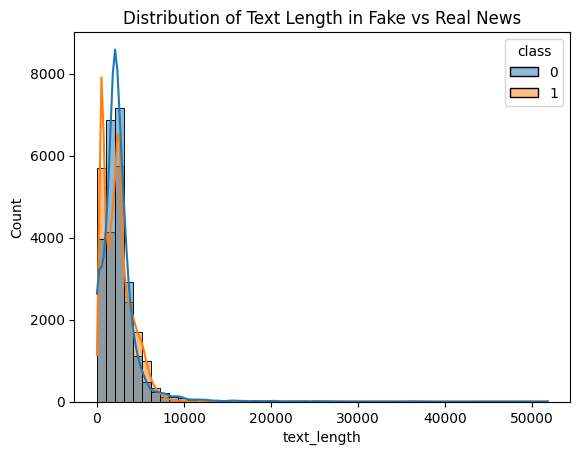

In [19]:
df["text_length"] = df["text"].apply(len)
print(df["text_length"].describe())  # Summary of text lengths

# Visualize text length distribution
sns.histplot(data=df, x="text_length", hue="class", bins=50, kde=True)
plt.title("Distribution of Text Length in Fake vs Real News")
plt.show()

In [20]:
df = df.dropna(subset=["text"])

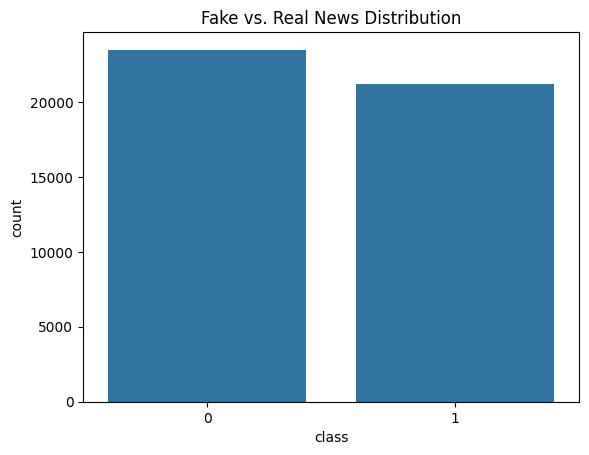

In [21]:
sns.countplot(x=df["class"])
plt.title("Fake vs. Real News Distribution")
plt.show()

In [22]:
# Compute Text Length
df["text_length"] = df["text"].apply(len)

# Splitting fake and real news data
fake_news = df[df["class"] == 0]
real_news = df[df["class"] == 1]


In [23]:
# Performing T-test (assumes normality)
t_stat, p_val_ttest = stats.ttest_ind(fake_news["text_length"], real_news["text_length"], equal_var=False)

# Performing Mann-Whitney U Test (non-parametric)
u_stat, p_val_mannwhitney = stats.mannwhitneyu(fake_news["text_length"], real_news["text_length"], alternative='two-sided')

# Displaying results
print(f"📌 T-Test Results:")
print(f"   - T-statistic: {t_stat:.4f}")
print(f"   - p-value: {p_val_ttest:.4f}")

print(f"\n📌 Mann-Whitney U Test Results:")
print(f"   - U-statistic: {u_stat:.4f}")
print(f"   - p-value: {p_val_mannwhitney:.4f}")

# Interpretation
alpha = 0.05  # Significance level
if p_val_ttest < alpha:
    print("\n🚨 Reject the Null Hypothesis (T-test): There is a significant difference in text length between fake and real news.")
else:
    print("\n✅ Fail to Reject the Null Hypothesis (T-test): No significant difference in text length.")

if p_val_mannwhitney < alpha:
    print("\n🚨 Reject the Null Hypothesis (Mann-Whitney U test): There is a significant difference in text length.")
else:
    print("\n✅ Fail to Reject the Null Hypothesis (Mann-Whitney U test): No significant difference in text length.")

📌 T-Test Results:
   - T-statistic: 8.4019
   - p-value: 0.0000

📌 Mann-Whitney U Test Results:
   - U-statistic: 252658519.0000
   - p-value: 0.0072

🚨 Reject the Null Hypothesis (T-test): There is a significant difference in text length between fake and real news.

🚨 Reject the Null Hypothesis (Mann-Whitney U test): There is a significant difference in text length.


In [24]:
# Compute Lexical Diversity (Unique Words / Total Words)
df["lexical_diversity"] = df["text"].apply(lambda x: len(set(x.split())) / len(x.split()) if len(x.split()) > 0 else 0)

# Splitting fake and real news data
fake_news = df[df["class"] == 0]
real_news = df[df["class"] == 1]

# Performing T-test (assumes normality)
t_stat, p_val_ttest = stats.ttest_ind(fake_news["lexical_diversity"], real_news["lexical_diversity"], equal_var=False)

# Performing Mann-Whitney U Test (non-parametric)
u_stat, p_val_mannwhitney = stats.mannwhitneyu(fake_news["lexical_diversity"], real_news["lexical_diversity"], alternative='two-sided')

# Displaying results
print(f"📌 T-Test Results:")
print(f"   - T-statistic: {t_stat:.4f}")
print(f"   - p-value: {p_val_ttest:.4f}")

print(f"\n📌 Mann-Whitney U Test Results:")
print(f"   - U-statistic: {u_stat:.4f}")
print(f"   - p-value: {p_val_mannwhitney:.4f}")

# Interpretation
alpha = 0.05  # Significance level
if p_val_ttest < alpha:
    print("\n🚨 Reject the Null Hypothesis (T-test): There is a significant difference in lexical diversity between fake and real news.")
else:
    print("\n✅ Fail to Reject the Null Hypothesis (T-test): No significant difference in lexical diversity.")

if p_val_mannwhitney < alpha:
    print("\n🚨 Reject the Null Hypothesis (Mann-Whitney U test): There is a significant difference in lexical diversity.")
else:
    print("\n✅ Fail to Reject the Null Hypothesis (Mann-Whitney U test): No significant difference in lexical diversity.")

📌 T-Test Results:
   - T-statistic: -25.3396
   - p-value: 0.0000

📌 Mann-Whitney U Test Results:
   - U-statistic: 219624544.0000
   - p-value: 0.0000

🚨 Reject the Null Hypothesis (T-test): There is a significant difference in lexical diversity between fake and real news.

🚨 Reject the Null Hypothesis (Mann-Whitney U test): There is a significant difference in lexical diversity.


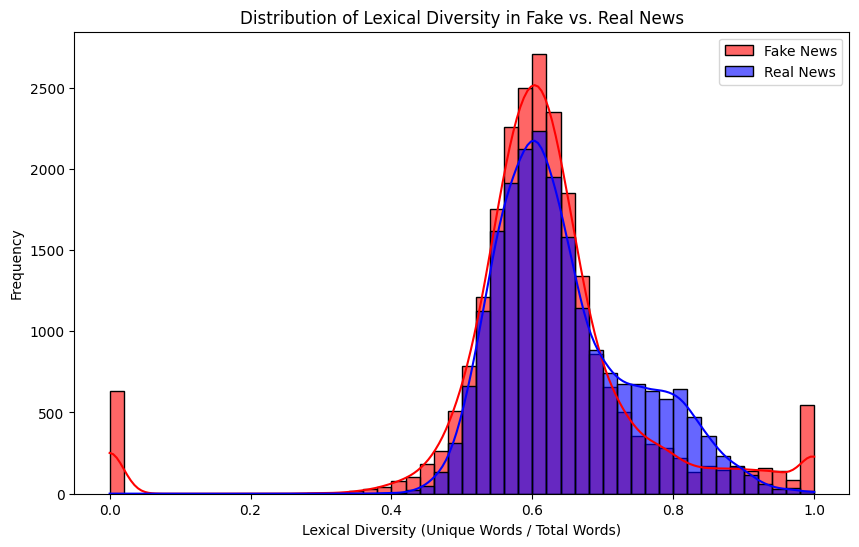

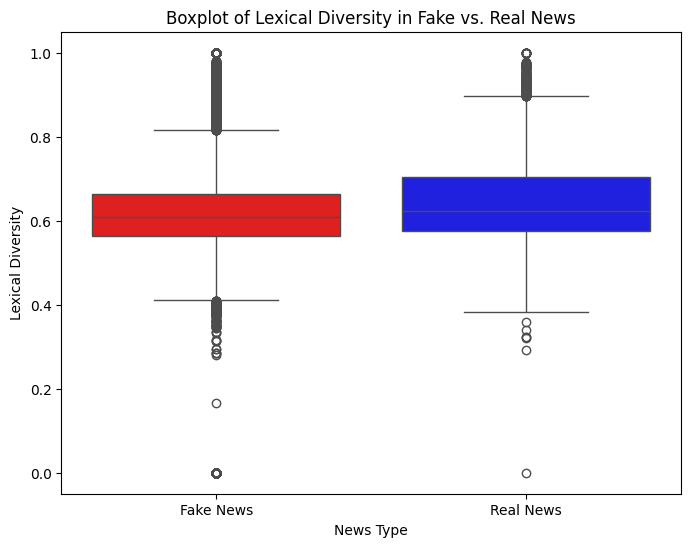

In [25]:
# Histogram of Lexical Diversity
plt.figure(figsize=(10, 6))
sns.histplot(fake_news["lexical_diversity"], bins=50, color="red", label="Fake News", kde=True, alpha=0.6)
sns.histplot(real_news["lexical_diversity"], bins=50, color="blue", label="Real News", kde=True, alpha=0.6)
plt.xlabel("Lexical Diversity (Unique Words / Total Words)")
plt.ylabel("Frequency")
plt.title("Distribution of Lexical Diversity in Fake vs. Real News")
plt.legend()
plt.show()

# Boxplot of Lexical Diversity
plt.figure(figsize=(8, 6))
sns.boxplot(x="class", y="lexical_diversity", hue="class", data=df, palette={0: "red", 1: "blue"}, dodge=False)
plt.xticks([0, 1], ["Fake News", "Real News"])
plt.xlabel("News Type")
plt.ylabel("Lexical Diversity")
plt.title("Boxplot of Lexical Diversity in Fake vs. Real News")
plt.legend([], [], frameon=False)  # Hides duplicate legend
plt.show()

# Cleaning and Text normalization

In [26]:
stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

In [27]:
from nltk.tokenize import TreebankWordTokenizer
tokenizer = TreebankWordTokenizer()

def clean_text(text):
    text = text.lower()
    text = re.sub(r'\d+', '', text)
    text = text.translate(str.maketrans('', '', string.punctuation))
    text = re.sub(r'\s+', ' ', text)
    tokens = tokenizer.tokenize(text)  # ← no dependency on punkt!
    tokens = [lemmatizer.lemmatize(word) for word in tokens if word not in stop_words]
    return ' '.join(tokens)

In [28]:
# Apply cleaning
data['text'] = data['title'].fillna('') + ' ' + data['text'].fillna('')
data['clean_text'] = data['text'].apply(clean_text)

In [29]:
min_class_size = data['class'].value_counts().min()
balanced_data = pd.concat([
    resample(data[data['class'] == 0], replace=False, n_samples=min_class_size, random_state=42),
    resample(data[data['class'] == 1], replace=False, n_samples=min_class_size, random_state=42)
])

balanced_data = balanced_data.sample(frac=1, random_state=42).reset_index(drop=True)

# Show basic info
print(balanced_data['class'].value_counts())
balanced_data[['clean_text', 'class']].head()

class
0    21417
1    21417
Name: count, dtype: int64


,clean_text,class
0,white college snowflake ‘identify’ black…call ...,0
1,top house democrat hopeful action puerto rico ...,1
2,trump sander win big michigan – trump clinton ...,0
3,neocon nightmare trump want ‘get along foreign...,0
4,gop governor demand ‘thank you’ rep john lewis...,0


# Feature Selection

In [30]:
# Step 1: TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer(max_features=5000, ngram_range=(1,2))
X = tfidf_vectorizer.fit_transform(balanced_data['clean_text'])

In [31]:
# Step 2: Labels
y = balanced_data['class']

# Step 3: Train/Test Split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [32]:
# Step 4: Baseline Model - Logistic Regression
model = LogisticRegression(max_iter=1000)
model.fit(X_train, y_train)

# Step 5: Evaluation
y_pred = model.predict(X_test)
print("Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\nClassification Report:")
print(classification_report(y_test, y_pred))

Confusion Matrix:
[[4305   57]
 [  21 4184]]

Classification Report:
              precision    recall  f1-score   support

           0       1.00      0.99      0.99      4362
           1       0.99      1.00      0.99      4205

    accuracy                           0.99      8567
   macro avg       0.99      0.99      0.99      8567
weighted avg       0.99      0.99      0.99      8567



In [33]:
# Get feature names
feature_names = tfidf_vectorizer.get_feature_names_out()

# Get model coefficients (Logistic Regression)
coefs = model.coef_[0]

# Top indicative features for class 1 (Real News)
top_real_indices = np.argsort(coefs)[-20:]
top_real_features = [(feature_names[i], coefs[i]) for i in top_real_indices]

# Top indicative features for class 0 (Fake News)
top_fake_indices = np.argsort(coefs)[:20]
top_fake_features = [(feature_names[i], coefs[i]) for i in top_fake_indices]

print("🔵 Top words indicating REAL news:")
for word, score in reversed(top_real_features):
    print(f"{word:<20} {score:.4f}")

print("\n🔴 Top words indicating FAKE news:")
for word, score in top_fake_features:
    print(f"{word:<20} {score:.4f}")

🔵 Top words indicating REAL news:
reuters              20.2274
said                 15.4154
washington reuters   8.5178
it                   5.3093
we                   5.0646
president donald     4.9882
the                  4.7737
washington           4.5089
wednesday            4.3718
tuesday              4.2522
reuters president    3.8465
friday               3.7742
thursday             3.7019
edt                  3.5827
monday               3.2916
minister             3.2418
nov                  3.2304
that                 3.2160
said statement       2.9412
democratic           2.7701

🔴 Top words indicating FAKE news:
video                -9.3795
via                  -7.7087
image                -6.8346
hillary              -5.5300
gop                  -5.0877
president trump      -5.0450
american             -4.3154
obama                -4.2929
mr                   -4.1985
image via            -4.0501
even                 -3.9743
like                 -3.8651
america              

In [34]:
from transformers import DistilBertTokenizerFast, TFDistilBertForSequenceClassification
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix
import tensorflow as tf
import numpy as np

# ✅ Step 1: Prepare text & labels
texts = balanced_data['text'].tolist()
labels = balanced_data['class'].tolist()

X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

# ✅ Step 2: Tokenize using HuggingFace tokenizer
tokenizer = DistilBertTokenizerFast.from_pretrained('distilbert-base-uncased')

train_encodings = tokenizer(X_train, truncation=True, padding=True, max_length=512)
test_encodings = tokenizer(X_test, truncation=True, padding=True, max_length=512)

# ✅ Step 3: Convert to TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((
    dict(train_encodings),
    y_train
)).batch(16)

test_dataset = tf.data.Dataset.from_tensor_slices((
    dict(test_encodings),
    y_test
)).batch(16)

# ✅ Step 4: Load pre-trained DistilBERT model
model = TFDistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)

# ✅ Step 5: Compile the model
model.compile(
    optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=5e-5),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics=['accuracy']
)

# ✅ Step 6: Train the model
model.fit(train_dataset, epochs=2)

# ✅ Step 7: Predict and evaluate
y_probs = model.predict(test_dataset).logits
y_pred = np.argmax(y_probs, axis=1)

print("📊 Confusion Matrix:")
print(confusion_matrix(y_test, y_pred))
print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

Some weights of the PyTorch model were not used when initializing the TF 2.0 model TFDistilBertForSequenceClassification: ['vocab_layer_norm.weight', 'vocab_transform.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.bias']
- This IS expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model trained on another task or with another architecture (e.g. initializing a TFBertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing TFDistilBertForSequenceClassification from a PyTorch model that you expect to be exactly identical (e.g. initializing a TFBertForSequenceClassification model from a BertForSequenceClassification model).
Some weights or buffers of the TF 2.0 model TFDistilBertForSequenceClassification were not initialized from the PyTorch model and are newly initialized: ['pre_classifier.weight', 'pre_classifier.bias', 'classifier.weight', 'classifier.bias']
You should 

Epoch 1/2
2142/2142 [==============================] - 1931s 895ms/step - loss: 0.0142 - accuracy: 0.9964
Epoch 2/2
536/536 [==============================] - 162s 300ms/step
📊 Confusion Matrix:
[[4362    0]
 [   0 4205]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       1.00      1.00      1.00      4362
           1       1.00      1.00      1.00      4205

    accuracy                           1.00      8567
   macro avg       1.00      1.00      1.00      8567
weighted avg       1.00      1.00      1.00      8567



In [35]:
# Step 1: Prepare new dataset (map labels)
df_news['class'] = df_news['label'].map({'FAKE': 0, 'REAL': 1})

# Step 2: Tokenize using the same tokenizer
new_encodings = tokenizer(
    df_news['text'].tolist(),
    truncation=True,
    padding=True,
    max_length=512
)

# Step 3: Create TensorFlow dataset
new_dataset = tf.data.Dataset.from_tensor_slices((
    dict(new_encodings),
    df_news['class'].tolist()
)).batch(16)

# Step 4: Predict using trained BERT model
new_probs = model.predict(new_dataset).logits
new_preds = np.argmax(new_probs, axis=1)

# Step 5: Evaluation
print("📊 Confusion Matrix:")
print(confusion_matrix(df_news['class'], new_preds))

print("\n📋 Classification Report:")
print(classification_report(df_news['class'], new_preds))

396/396 [==============================] - 119s 301ms/step
📊 Confusion Matrix:
[[2274  890]
 [2178  993]]

📋 Classification Report:
              precision    recall  f1-score   support

           0       0.51      0.72      0.60      3164
           1       0.53      0.31      0.39      3171

    accuracy                           0.52      6335
   macro avg       0.52      0.52      0.50      6335
weighted avg       0.52      0.52      0.49      6335



In [36]:
!pip install transformers

In [37]:
from transformers import pipeline
import random

# STEP 2: Load GPT-2 text generation model
generator = pipeline("text-generation", model="gpt2")

# STEP 3: Define prompt categories

clickbait_prompts = [
    "You won't believe what happened:",
    "This will shock you:",
    "Doctors hate this trick:",
    "Top 10 reasons why:",
    "This changes everything:",
    "What they don’t want you to know:",
    "Is this the end of",
    "Here’s what really happened with:",
    "Everyone is talking about:",
    "This is going viral:"
]

news_prompts = [
    "Breaking news:",
    "Government announces:",
    "Experts reveal:",
    "President confirms:",
    "Police report that:",
    "New study finds:",
    "Officials say:",
    "Report shows:",
    "Investigation underway after:",
    "Minister states:"
]

science_prompts = [
    "Scientists discover:",
    "AI research shows:",
    "NASA reveals:",
    "Quantum breakthrough in:",
    "Dark matter detected in:",
    "The vaccine causes:",
    "Aliens confirmed near:",
    "Biolab leak theory proves:",
    "New variant found in:",
    "CERN scientists report:"
]

# Combine all prompts into one pool
all_prompts = clickbait_prompts + news_prompts + science_prompts

# STEP 4: Generate synthetic headlines
synthetic_headlines = []

# You can adjust how many total you want (e.g., 300)
num_total = 300
num_per_prompt = 5

for prompt in random.sample(all_prompts, k=len(all_prompts)):
    outputs = generator(
        prompt,
        max_length=20,
        num_return_sequences=num_per_prompt,
        do_sample=True,
        top_k=50,
        temperature=0.9
    )
    for output in outputs:
        headline = output['generated_text'].strip().replace("\n", " ")
        synthetic_headlines.append(headline)
    if len(synthetic_headlines) >= num_total:
        break

# STEP 5: Preview results
print("Sample bot-generated headlines:")
for i, h in enumerate(synthetic_headlines[:10]):
    print(f"{i+1}. {h}")

print(f"\n✅ Total generated: {len(synthetic_headlines)} headlines")

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/124 [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cuda:0
Truncation was not explicitly activated but `max_length` is provided a specific value, please use `truncation=True` to explicitly truncate examples to max length. Defaulting to 'longest_first' truncation strategy. If you encode pairs of sequences (GLUE-style) with the tokenizer you can select this strategy more precisely by providing a specific strategy to `truncation`.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.
Setting `pad_token_id` to 

Sample bot-generated headlines:
1. This will shock you: How could you be so shocked that your child doesn't know anything about it
2. This will shock you: if you are a woman and you want to have a woman's body,
3. This will shock you: The man who helped to open the first World Trade Center in New York,
4. This will shock you:  In many ways, this is true. The "free market"
5. This will shock you: When the whole of Western civilisation and the rest of society collapsed because of slavery
6. Quantum breakthrough in: The Big Bang Theory  This week is dedicated to the life of the
7. Quantum breakthrough in:  The MALF project and MALF's "Laser
8. Quantum breakthrough in:  1. Artificial Intelligence and Machine Learning  2. Natural Language
9. Quantum breakthrough in:  – It is already possible to create more than one double-pre
10. Quantum breakthrough in:  Folding magnetic resonance imaging to characterize the structure and function of atoms

✅ Total generated: 150 headlines


In [38]:
human_headlines = df_news['title'].dropna().tolist()

In [39]:
# Label: 1 = Human, 0 = Bot
labeled_human = [(h, 1) for h in human_headlines[:150]]
labeled_bot = [(b, 0) for b in synthetic_headlines[:150]]

# Combine & shuffle
import random
all_headlines = labeled_human + labeled_bot
random.shuffle(all_headlines)

texts = [x[0] for x in all_headlines]
labels = [x[1] for x in all_headlines]

In [40]:
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(texts, labels, test_size=0.2, random_state=42)

📊 Confusion Matrix:


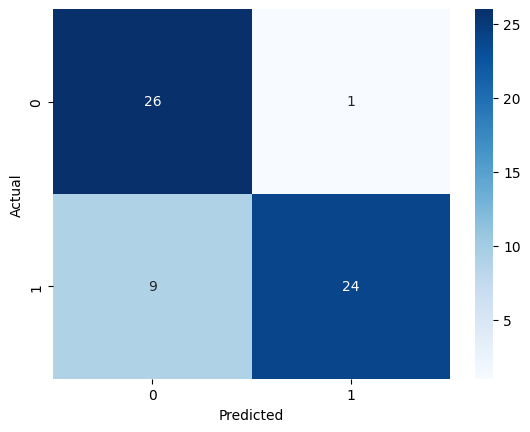


📋 Classification Report:
              precision    recall  f1-score   support

         Bot       0.74      0.96      0.84        27
       Human       0.96      0.73      0.83        33

    accuracy                           0.83        60
   macro avg       0.85      0.85      0.83        60
weighted avg       0.86      0.83      0.83        60



In [41]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: TF-IDF Vectorizer
vectorizer = TfidfVectorizer(max_features=5000)
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

# Step 2: Train Logistic Regression
model = LogisticRegression()
model.fit(X_train_vec, y_train)

# Step 3: Predict & Evaluate
y_pred = model.predict(X_test_vec)

print("📊 Confusion Matrix:")
cm = confusion_matrix(y_test, y_pred)
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("\n📋 Classification Report:")
print(classification_report(y_test, y_pred, target_names=["Bot", "Human"]))